In [1]:
import json
import re
import string
import random
from itertools import islice
from pathlib import Path
from typing import NamedTuple

from swda import CorpusReader
import pandas as pd
import spacy
from spacy.tokens import Span, Doc
from spacy.tokenizer import Tokenizer
from spacy import displacy
from tqdm import tqdm
from cytoolz import groupby

%load_ext autoreload
%autoreload 2

In [2]:
from daseg.data import SwdaDataset, to_transformers_ner_dataset

dataset = SwdaDataset.from_path('deps/swda/swda')

transcript 1155


In [3]:
call_ids = dataset.call_ids
calls = dataset.calls
call = dataset.calls[0]
call[:10]

[FunctionalSegment(text='Okay.', dialog_act='Other', speaker='A', is_continuation=False),
 FunctionalSegment(text='So,', dialog_act='Wh-Question', speaker='A', is_continuation=False),
 FunctionalSegment(text='I guess,', dialog_act='Declarative Yes-No-Question', speaker='B', is_continuation=False),
 FunctionalSegment(text='What kind of experience do you, do you have, then with child care?', dialog_act='Wh-Question', speaker='A', is_continuation=True),
 FunctionalSegment(text='I think, uh, I wonder if that worked.', dialog_act='Declarative Yes-No-Question', speaker='B', is_continuation=True),
 FunctionalSegment(text='Does it say something?', dialog_act='Yes-No-Question', speaker='A', is_continuation=False),
 FunctionalSegment(text='I think it usually does.', dialog_act='Statement-non-opinion', speaker='B', is_continuation=False),
 FunctionalSegment(text='You might try, uh,', dialog_act='Action-directive', speaker='B', is_continuation=False),
 FunctionalSegment(text="I don't know,", dialo

In [4]:
texts_by_act = dataset.acts_with_examples()

In [5]:
len(texts_by_act.keys()), texts_by_act.keys()

(45,
 dict_keys(['3rd-party-talk', 'Acknowledge (Backchannel)', 'Action-directive', 'Affirmative non-yes answers', 'Agree/Accept', 'Answer dispreferred', 'Apology', 'Appreciation', 'Backchannel in question form', 'Collaborative Completion', 'Conventional-closing', 'Conventional-opening', 'Declarative Wh-Question', 'Declarative Yes-No-Question', 'Dispreferred answers', 'Downplayer', 'Exclamation', 'Hedge', 'Hold before answer/agreement', 'Negative non-no answers', 'No answers', 'Non-verbal', 'Offers, Options Commits', 'Open-Question', 'Or-Clause', 'Or-question', 'Other', 'Other answers', 'Quoted Material', 'Reject', 'Repeat-phrase', 'Response Acknowledgement', 'Rhetorical-Questions', 'Self-talk', 'Signal-non-understanding', 'Statement expanding y/n answer', 'Statement-non-opinion', 'Statement-opinion', 'Summarize/reformulate', 'Tag-Question', 'Thanking', 'Uninterpretable', 'Wh-Question', 'Yes answers', 'Yes-No-Question']))

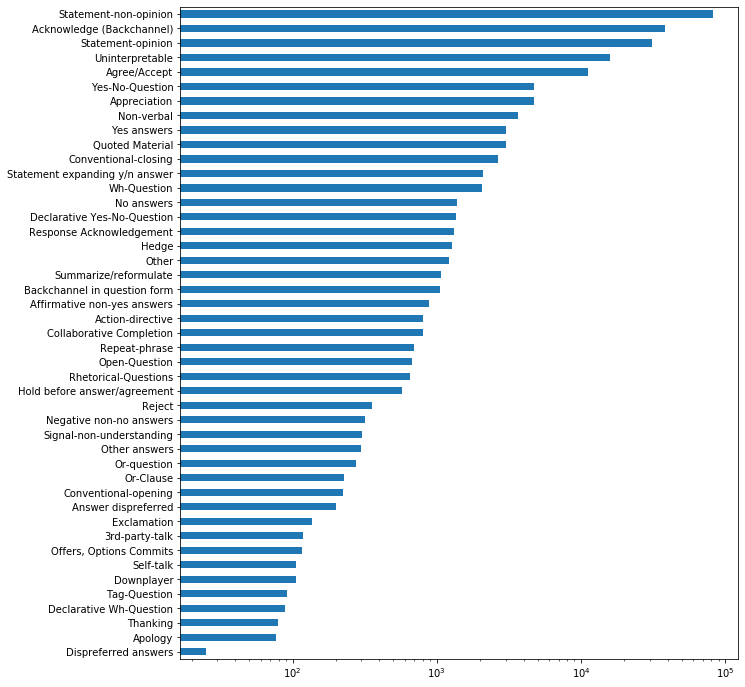

In [6]:
pd.Series({act: len(texts) for act, texts in texts_by_act.items()}).sort_values().plot.barh(figsize=(10, 12), logx=True)

## Number of turns distribution

In [7]:
sum(map(len, texts_by_act.values()))

221616

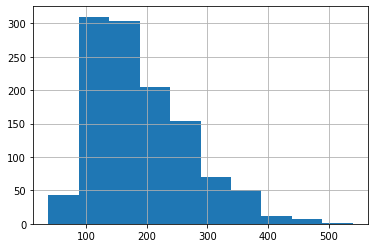

In [8]:
pd.Series([len(call) for call in calls]).hist()

## Word length distribution

In [9]:
special_symbols = dataset.special_symbols()
len(special_symbols)

584

In [10]:
words_len_dist = pd.Series([sum(len(u.split()) for u, _, _, _ in call) for call in calls])

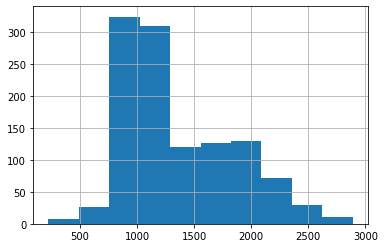

In [11]:
words_len_dist.hist()

In [12]:
to_transformers_ner_dataset(calls[1073], special_symbols)[:20]

['Brian B-Conventional-opening',
 'in I-Conventional-opening',
 'Plano I-Conventional-opening',
 ', I-Conventional-opening',
 'Texas I-Conventional-opening',
 '. I-Conventional-opening',
 'How I-Conventional-opening',
 'are I-Conventional-opening',
 'you I-Conventional-opening',
 'doing I-Conventional-opening',
 'today I-Conventional-opening',
 '? I-Conventional-opening',
 '<TURN> O',
 'Hi B-Conventional-opening',
 ', I-Conventional-opening',
 'fine B-Conventional-opening',
 ', I-Conventional-opening',
 'I B-Statement-non-opinion',
 "'m I-Statement-non-opinion",
 'Nancy I-Statement-non-opinion']

In [13]:
if False:
    for split_name, split_dataset in dataset.train_dev_test_split().items():
        split_dataset.dump_for_transformers_ner(f'{split_name}.txt.tmp')
else:
    print("DATASETS NOT WRITTEN TO DISK")

DATASETS NOT WRITTEN TO DISK


# Visualize

In [14]:
call[:20]

[FunctionalSegment(text='Okay.', dialog_act='Other', speaker='A', is_continuation=False),
 FunctionalSegment(text='So,', dialog_act='Wh-Question', speaker='A', is_continuation=False),
 FunctionalSegment(text='I guess,', dialog_act='Declarative Yes-No-Question', speaker='B', is_continuation=False),
 FunctionalSegment(text='What kind of experience do you, do you have, then with child care?', dialog_act='Wh-Question', speaker='A', is_continuation=True),
 FunctionalSegment(text='I think, uh, I wonder if that worked.', dialog_act='Declarative Yes-No-Question', speaker='B', is_continuation=True),
 FunctionalSegment(text='Does it say something?', dialog_act='Yes-No-Question', speaker='A', is_continuation=False),
 FunctionalSegment(text='I think it usually does.', dialog_act='Statement-non-opinion', speaker='B', is_continuation=False),
 FunctionalSegment(text='You might try, uh,', dialog_act='Action-directive', speaker='B', is_continuation=False),
 FunctionalSegment(text="I don't know,", dialo

In [15]:
call.render(max_turns=20)

# Read model predictions

In [16]:
preds_path = '/home/pzelasko/transformers/examples/ner/swda-xlmroberta-kosher-split-t43/test_predictions.txt'
calls = SwdaDataset.from_transformers_predictions(preds_path)

## Render model predictions

In [17]:
idx = 2

In [18]:
calls.calls[idx].render(max_turns=20)